# Qualité de l'image : calcul du rapport signal sur bruit (SNR)

Toutes les images numériques sont affectées par le bruit, qui se manifeste par des fluctuations aléatoires des valeurs de pixels. Le **Rapport Signal sur Bruit (SNR - Signal-to-Noise Ratio)** est une métrique fondamentale utilisée pour quantifier la qualité d'une image en évaluant la proportion du signal utile par rapport au bruit de fond.

Un SNR élevé indique que le signal d'intérêt est clairement discernable du bruit, ce qui est caractéristique d'une image de bonne qualité.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from matplotlib.patches import Rectangle

---

## Méthode de calcul du SNR

Une approche courante pour estimer le SNR d'une image est la suivante :

1.  **Sélection d'une Région d'Intérêt (ROI) pour le Signal** : Une zone de l'image contenant le signal d'intérêt (ex: tissu biologique) est identifiée.
2.  **Sélection d'une ROI pour le Bruit** : Une zone de l'image ne contenant que du bruit de fond (ex: air ambiant) est sélectionnée.
3.  **Calcul du SNR** : Le rapport est calculé en utilisant la formule :
    `SNR = Moyenne(ROI_signal) / Écart-type(ROI_bruit)`
    -   La moyenne du signal représente l'amplitude du signal utile.
    -   L'écart-type du bruit quantifie la variabilité (l'intensité) du bruit.

---

## Application : calcul du SNR sur une image IRM

Nous allons appliquer cette méthode pour calculer le SNR sur une image IRM du cerveau. Nous définirons manuellement une ROI pour le signal dans une région de tissu cérébral et une ROI pour le bruit dans l'arrière-plan (air).

*Note : Le fichier `sub-X_ses-Y_T2star.nii.gz` est un exemple de données d'imagerie cérébrale au format NIfTI.*

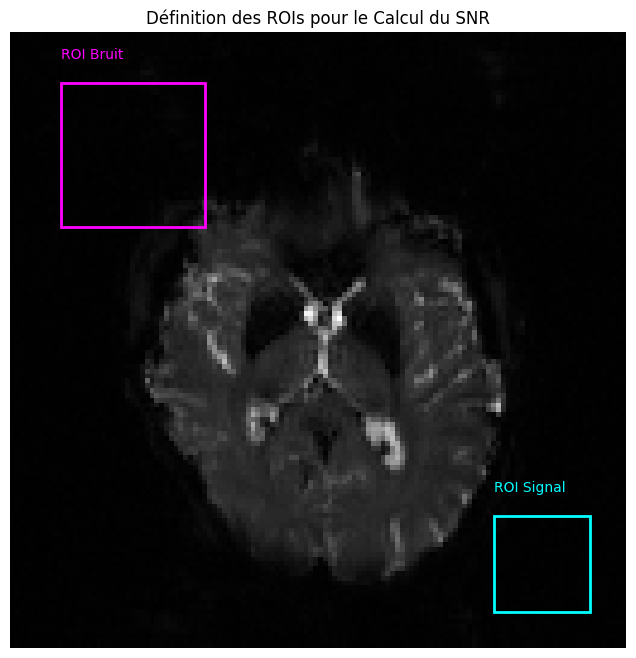

In [5]:
# Chargement de l'image T2-star
image_path = 'data/bids/anat/sub-X_ses-Y_T2star.nii.gz'
img_nifti = nib.load(image_path)
img_data = img_nifti.get_fdata()

# Sélection d'une coupe axiale médiane
slice_idx = img_data.shape[2] // 2
image_slice = np.rot90(img_data[:, :, slice_idx])

# Définition des coordonnées des ROIs [coin_x, coin_y, largeur, hauteur]
roi_signal_coords = [100, 100, 20, 20] # Exemple de ROI dans le tissu cérébral
roi_bruit_coords = [10, 10, 30, 30]   # Exemple de ROI dans l'air (bruit de fond)

# Visualisation de l'image et des ROIs définies
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_slice, cmap='gray')

# Dessin des rectangles pour les ROIs
rect_signal = Rectangle((roi_signal_coords[0], roi_signal_coords[1]), roi_signal_coords[2], roi_signal_coords[3], edgecolor='cyan', facecolor='none', lw=2)
rect_bruit = Rectangle((roi_bruit_coords[0], roi_bruit_coords[1]), roi_bruit_coords[2], roi_bruit_coords[3], edgecolor='magenta', facecolor='none', lw=2)
ax.add_patch(rect_signal)
ax.add_patch(rect_bruit)

ax.text(roi_signal_coords[0], roi_signal_coords[1] - 5, 'ROI Signal', color='cyan')
ax.text(roi_bruit_coords[0], roi_bruit_coords[1] - 5, 'ROI Bruit', color='magenta')

ax.set_title("Définition des ROIs pour le Calcul du SNR")
ax.axis('off')
plt.show()

---

## Calcul effectif du SNR

Après avoir défini les ROIs, nous extrayons les données de pixels correspondantes et appliquons la formule du SNR.

In [6]:
# Extraction des données des ROIs par slicing
x_s, y_s, w_s, h_s = roi_signal_coords
roi_signal = image_slice[y_s:y_s+h_s, x_s:x_s+w_s]

x_b, y_b, w_b, h_b = roi_bruit_coords
roi_bruit = image_slice[y_b:y_b+h_b, x_b:x_b+w_b]

# Calcul des statistiques nécessaires
mean_signal = np.mean(roi_signal)
std_bruit = np.std(roi_bruit)

# Calcul du SNR
snr = mean_signal / std_bruit

print(f"Moyenne du signal (ROI) : {mean_signal:.2f}")
print(f"Écart-type du bruit (ROI) : {std_bruit:.2f}")
print(f"Rapport Signal sur Bruit (SNR) : {snr:.2f}")

Moyenne du signal (ROI) : 18.47
Écart-type du bruit (ROI) : 27.51
Rapport Signal sur Bruit (SNR) : 0.67


---

## Calcul effectif du SNR

Le rapport signal/bruit (SNR, ou Signal-to-Noise Ratio) est une métrique cruciale pour évaluer la qualité d'une image.

SNR de l'image originale : 0.67
SNR de l'image bruitée : 0.33


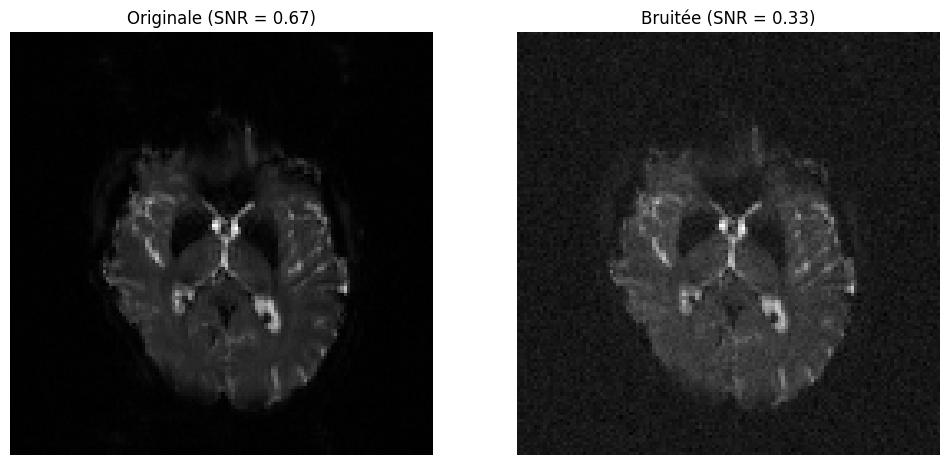

In [7]:
intensite_bruit_ajoute = 50
bruit_gaussien = np.random.normal(0, intensite_bruit_ajoute, image_slice.shape)
image_bruitee = image_slice + bruit_gaussien

# Recalcul du SNR pour l'image bruitée
roi_signal_bruitee = image_bruitee[y_s:y_s+h_s, x_s:x_s+w_s]
roi_bruit_bruitee = image_bruitee[y_b:y_b+h_b, x_b:x_b+w_b]

mean_signal_bruitee = np.mean(roi_signal_bruitee)
std_bruit_bruitee = np.std(roi_bruit_bruitee)
snr_bruitee = mean_signal_bruitee / std_bruit_bruitee

print(f"SNR de l'image originale : {snr:.2f}")
print(f"SNR de l'image bruitée : {snr_bruitee:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_slice, cmap='gray')
axes[0].set_title(f"Originale (SNR = {snr:.2f})")
axes[0].axis('off')

axes[1].imshow(image_bruitee, cmap='gray')
axes[1].set_title(f"Bruitée (SNR = {snr_bruitee:.2f})")
axes[1].axis('off')
plt.show()